In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from keras.models import Sequential, Model
from keras.layers import Dense, Input, GRU, Dropout
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model
from keras.src.layers import concatenate

from sklearn.preprocessing import MinMaxScaler

from scripts.process_dataset import read_dataset, read_simulation
from utils import draw_prediction, plot_loss

In [3]:
def predict(X, models, scaler):
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X)
    """
    X_trans = scaler.transform(X)
    Y_pred_trans = np.concatenate([model.predict(X_trans, verbose=0) for model in models], axis=1)
    Y_pred_trans_extended = np.concatenate([Y_pred_trans, np.zeros((Y_pred_trans.shape[0], X.shape[1]-Y_pred_trans.shape[1]))], axis=1)
    Y_pred = scaler.inverse_transform(Y_pred_trans_extended)[:, :Y_pred_trans.shape[1]]
    return Y_pred

In [4]:
def get_model(N, X, Y):
    model = Sequential([
        Input(shape=X.shape[1:]),
        Dense(N),
        Dense(Y.shape[1])
    ])
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(
        "toto.keras",
        #f"{folder_name}/{patch}.keras",  # Filepath to save the best model
        monitor="val_loss",  # Metric to monitor (e.g., validation accuracy)
        save_best_only=True,  # Save only the best model
        mode="min",  # "max" if monitoring validation accuracy, "min" for loss
        verbose=0  # Display messages when saving
    )
    model.fit(X, Y, epochs=70, batch_size=75, validation_split=0.2, verbose=0, callbacks=[checkpoint])
    return model

In [5]:
def next_state(state, next_sterile_pop, model):
    return np.concatenate([model.predict(state, verbose=0)] + [next_sterile_pop], axis=1).reshape(1, -1)

In [6]:
def moving_predict(X, model, scaler):
    X_trans = scaler.transform(X)
    initial_state = X_trans[0:1, :]
    sterile_pop = X_trans[:, 70:]
    states = [initial_state]
    last_state = initial_state
    for i in range(X.shape[0]-1):
        print(i)
        last_state = next_state(last_state, sterile_pop[i+1:i+2, :], model)
        states.append(last_state)
    Y_pred_trans = np.concatenate(states, axis=0)
    Y_pred_trans_extended = np.concatenate([Y_pred_trans, np.zeros((Y_pred_trans.shape[0], X.shape[1]-Y_pred_trans.shape[1]))], axis=1)
    Y_pred = scaler.inverse_transform(Y_pred_trans_extended)[:, :Y_pred_trans.shape[1]]
    return Y_pred

In [7]:
DATASET_NAME = "toto"
N_NEURAL = 32
DATASET_PATH = f"../dataset/{DATASET_NAME}"
X, Y = read_dataset(f"{DATASET_PATH}/train")
X = X.reshape((X.shape[0], X.shape[2]))
Y_extended = np.c_[Y, np.zeros((Y.shape[0], X.shape[1]-Y.shape[1]))]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X)
X_trans = scaler.transform(X)
Y_trans = scaler.transform(Y_extended)[:, :Y.shape[1]]

In [8]:
model = get_model(1000, X_trans, Y_trans)

I0000 00:00:1747224479.718388    1954 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46635 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:55:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │        81,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │        70,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,070 (590.12 KB)

 Trainable params: 151,070 (590.12 KB)

 Non-trainable params: 0 (0.00 B)

2025-05-14 12:08:01.244116: I external/local_xla/xla/service/service.cc:152] XLA service 0x79f40400a540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-14 12:08:01.244139: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-14 12:08:01.265067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747224481.333212    2055 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-14 12:08:01.839706: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_165', 8 bytes spill stores, 8 bytes spill loads

2025-05-14 12:08:02.252590: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memor

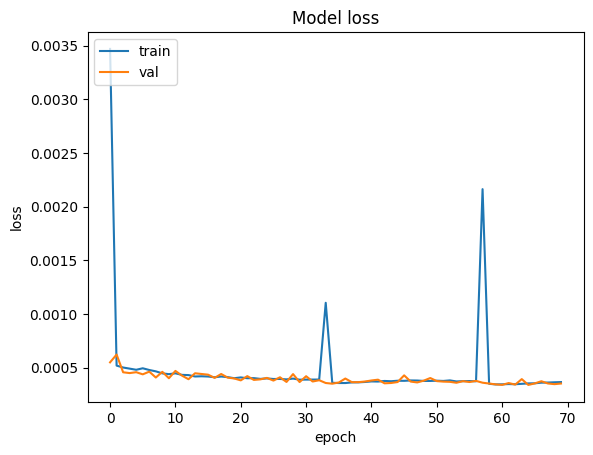

In [9]:
plot_loss(model)

In [10]:
simu_test, nb_sterile = read_simulation(f"{DATASET_PATH}/test/1/")
X_test = simu_test[:-1, :]
Y_test = simu_test[1:, :simu_test.shape[1]-nb_sterile]
Y_pred = scaler.inverse_transform(np.concatenate([model.predict(scaler.transform(X_test), verbose=0), np.zeros((X_test.shape[0], X_test.shape[1]-Y_test.shape[1]))], axis=1))
for i in range(10):
    draw_prediction(Y_test, Y_pred, i)


ValueError: not enough values to unpack (expected 2, got 0)

In [27]:
Y_pred_move = moving_predict(X_test, model, scaler)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


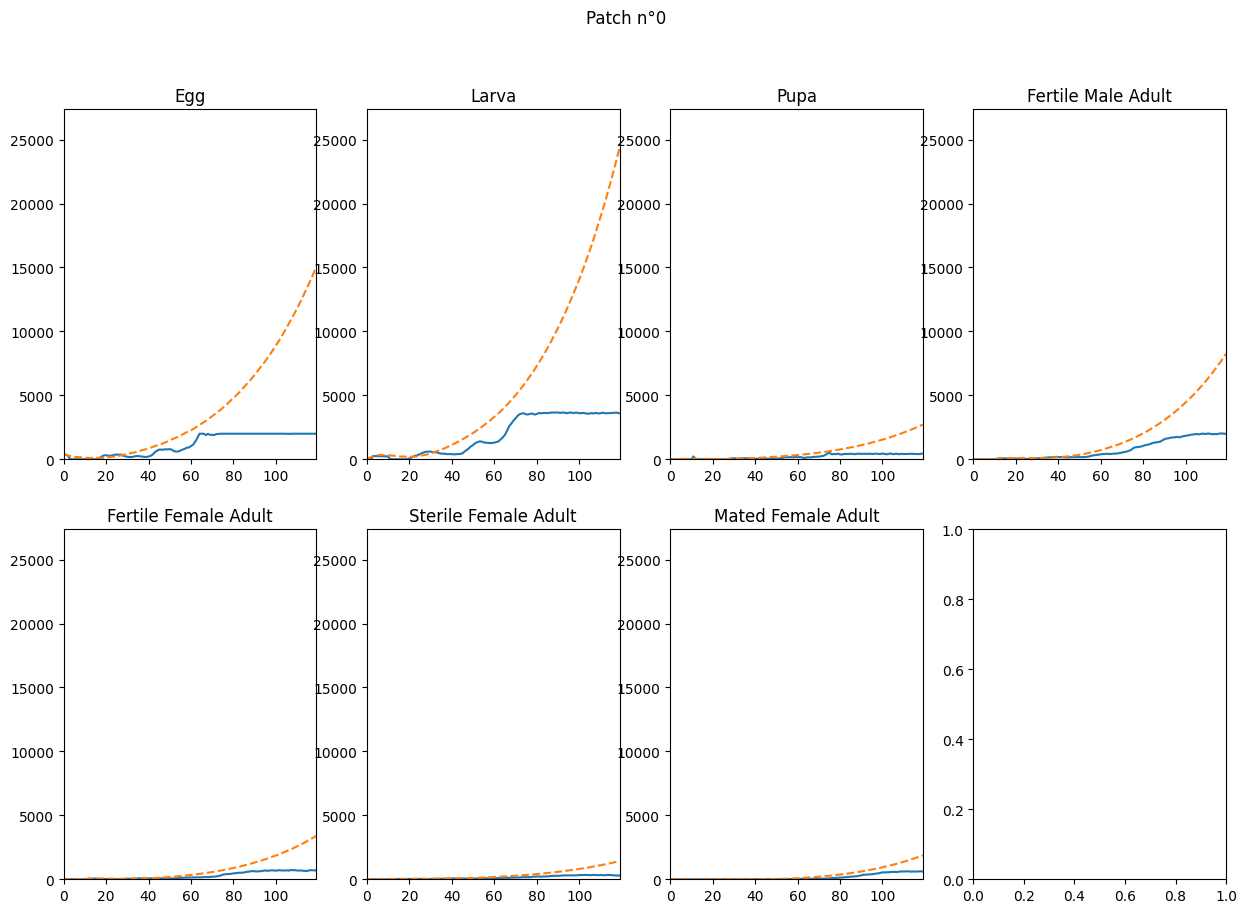

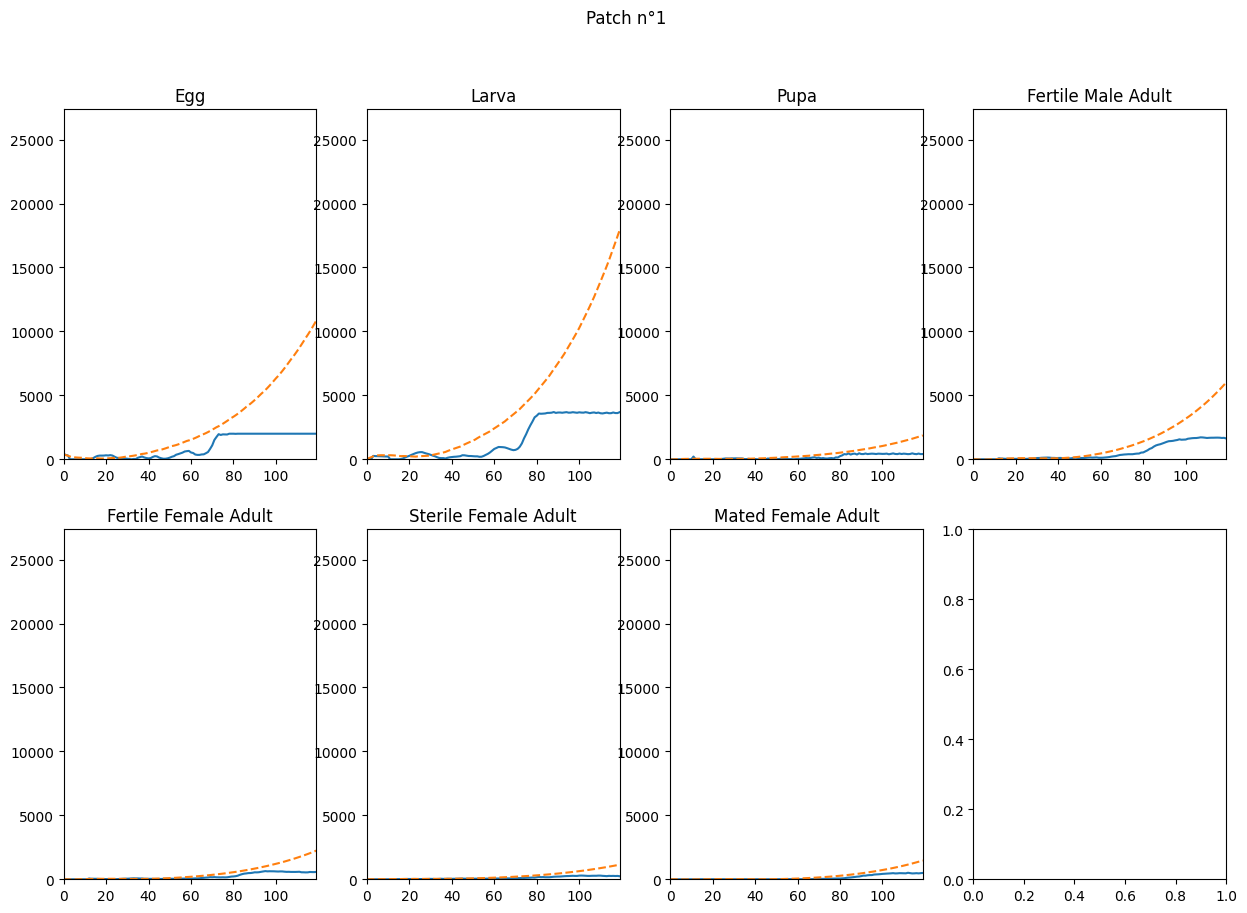

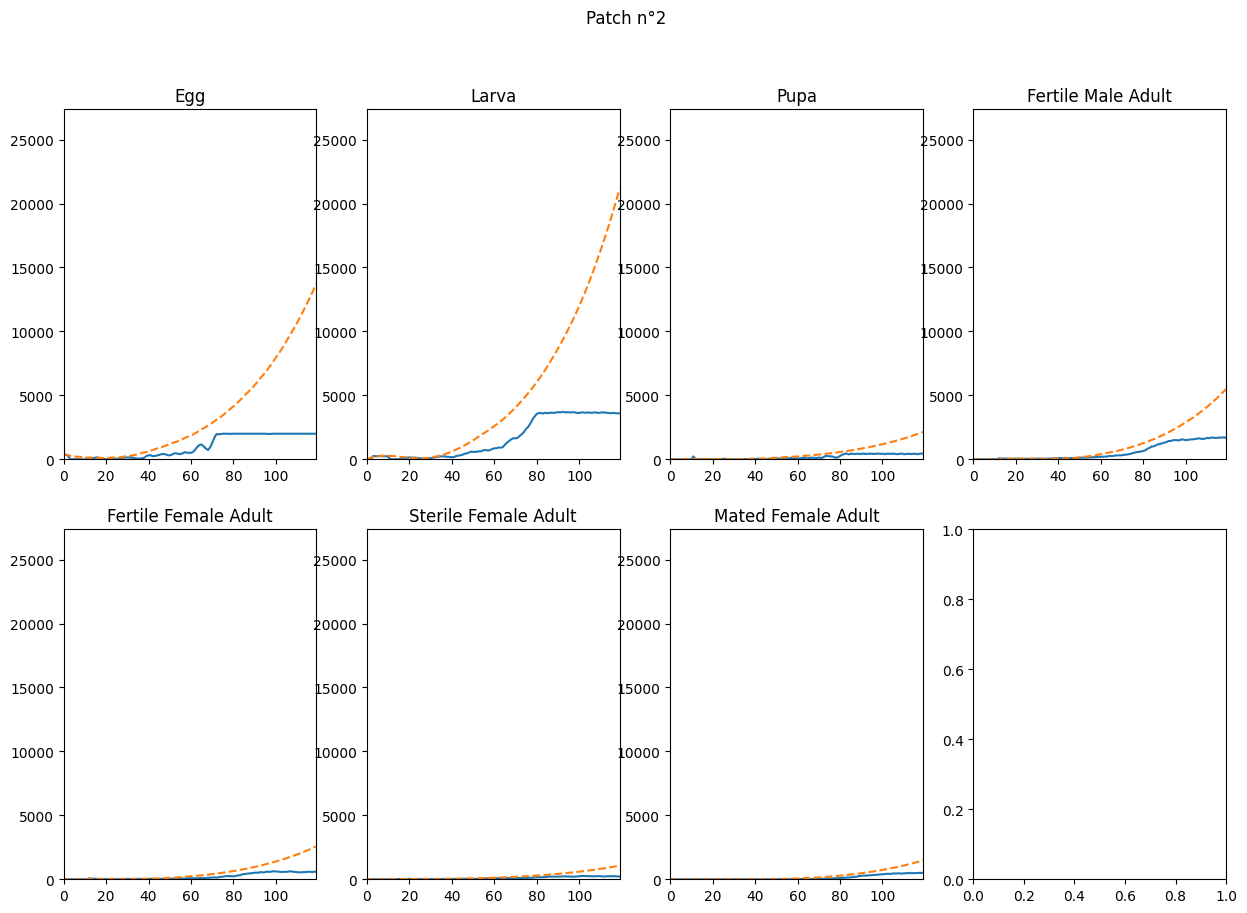

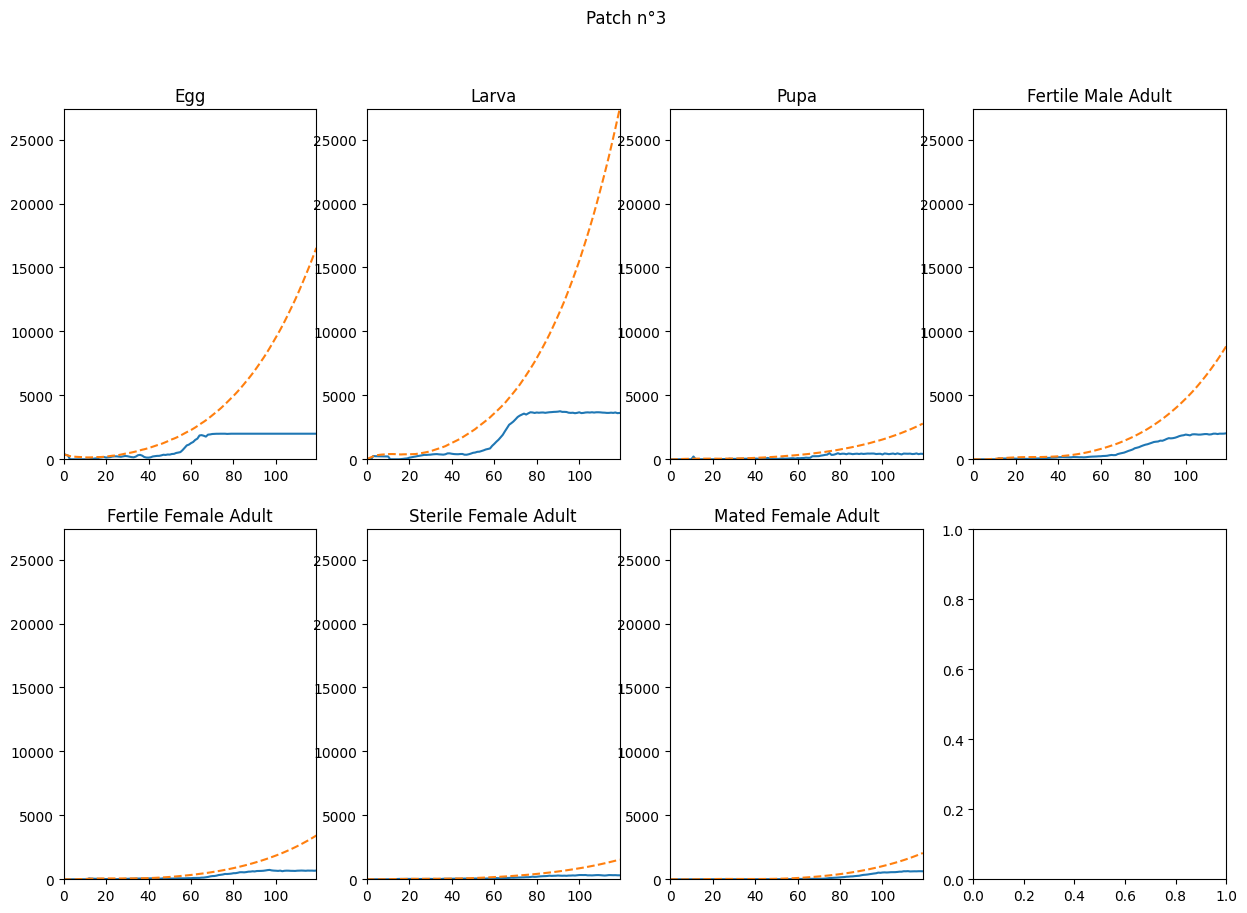

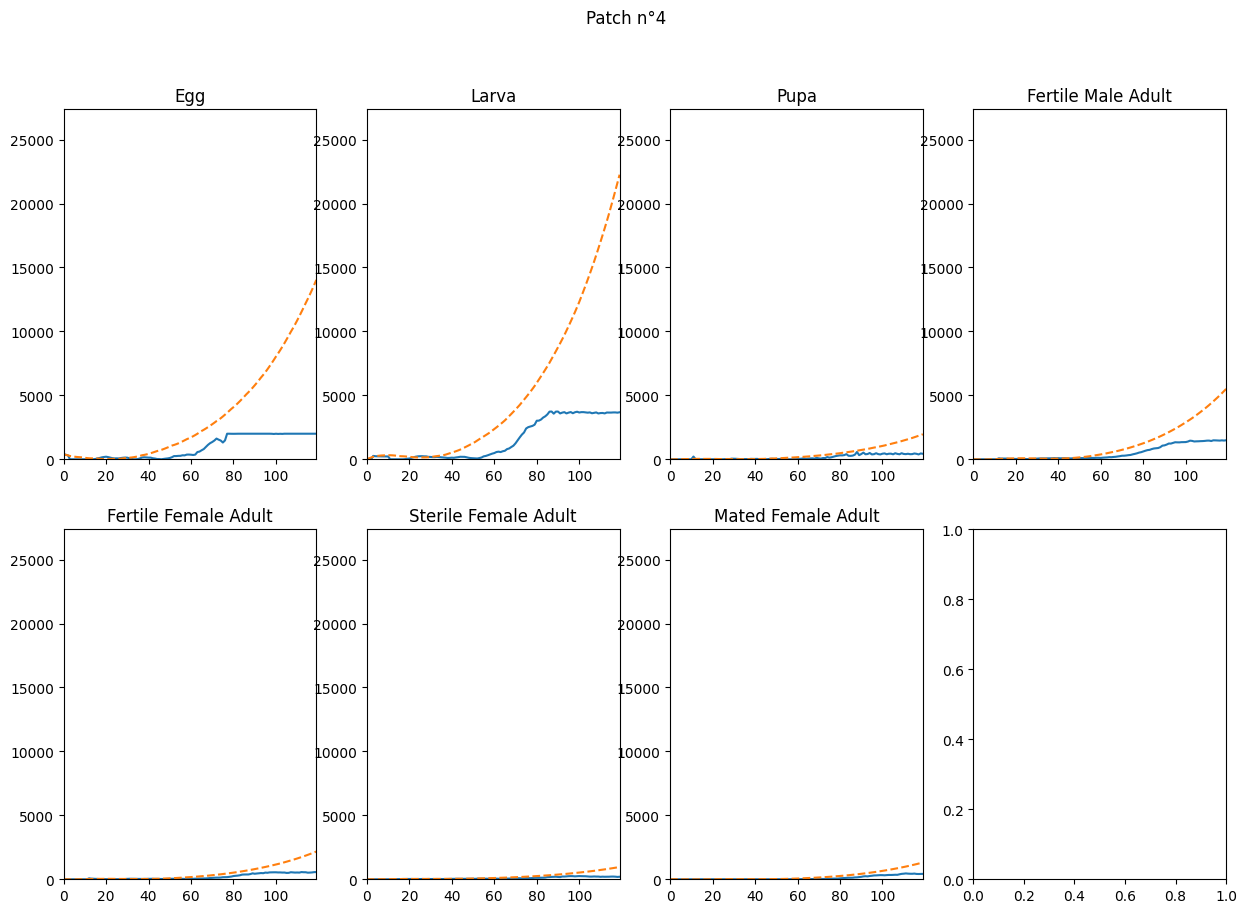

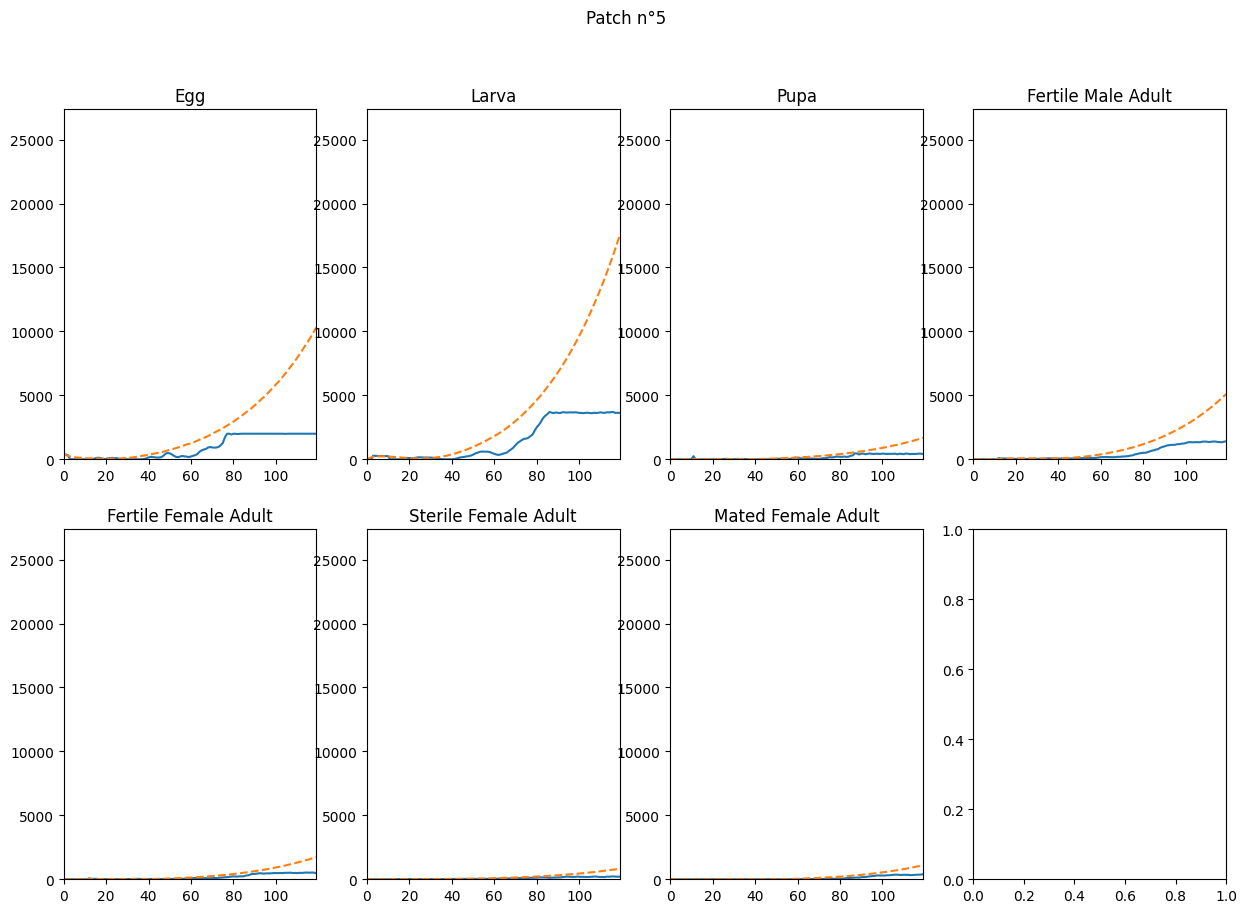

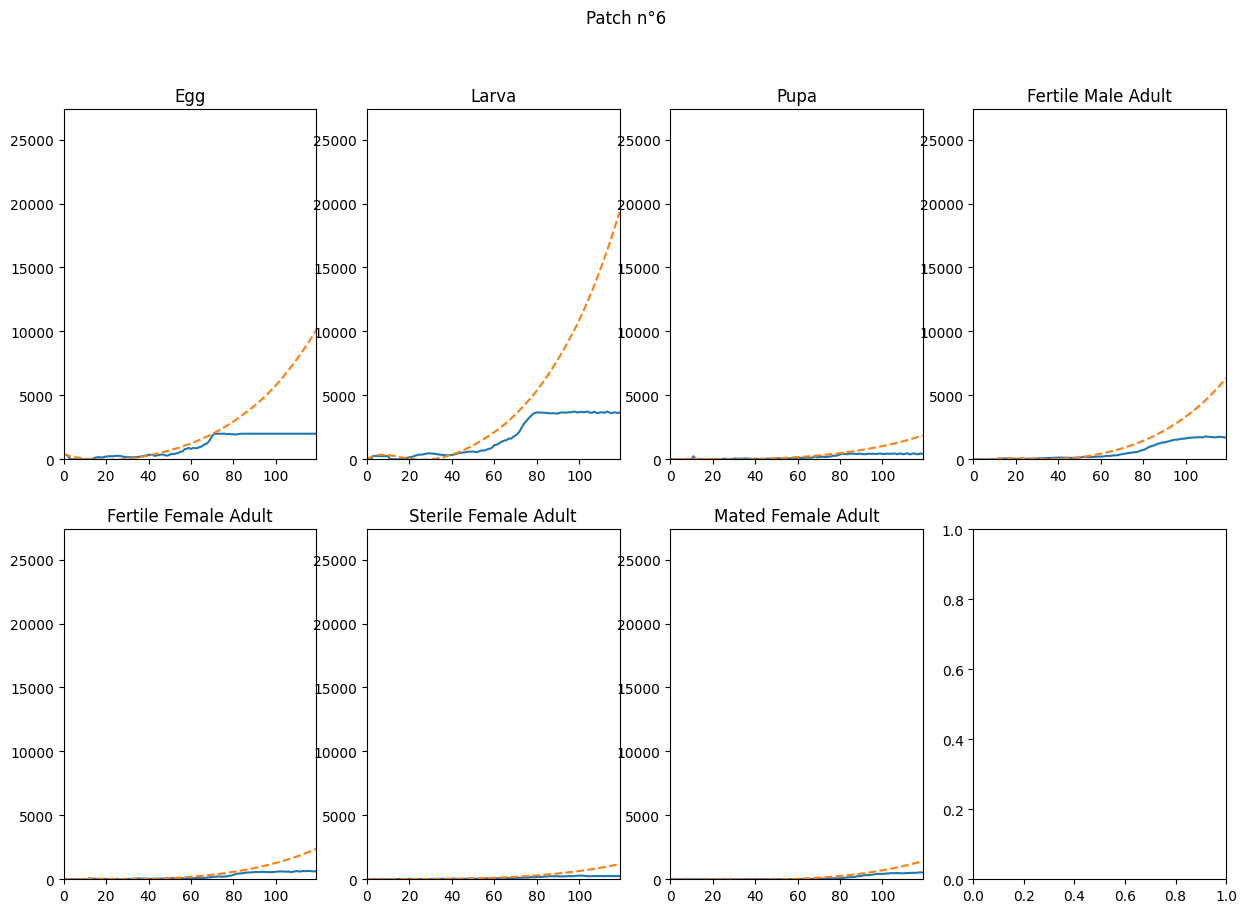

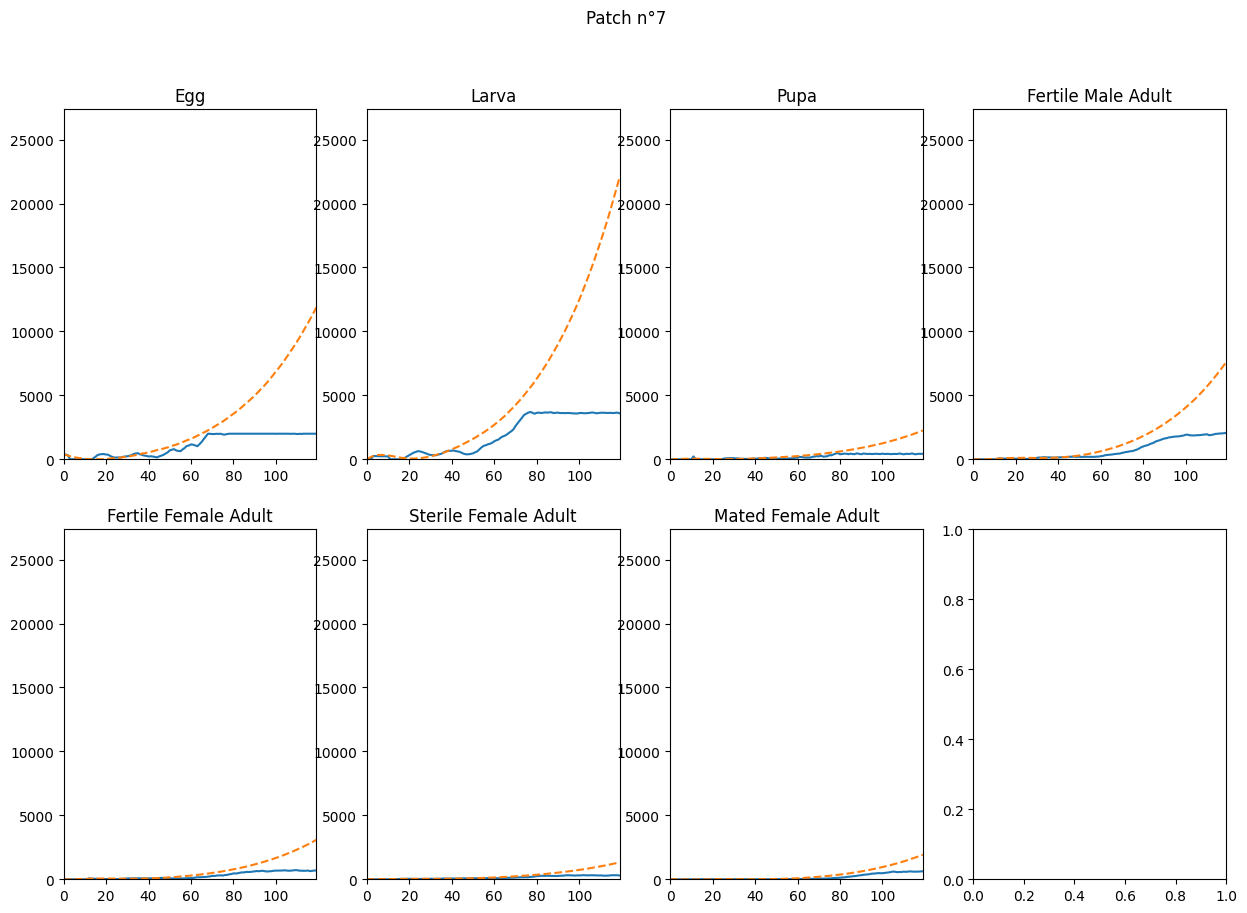

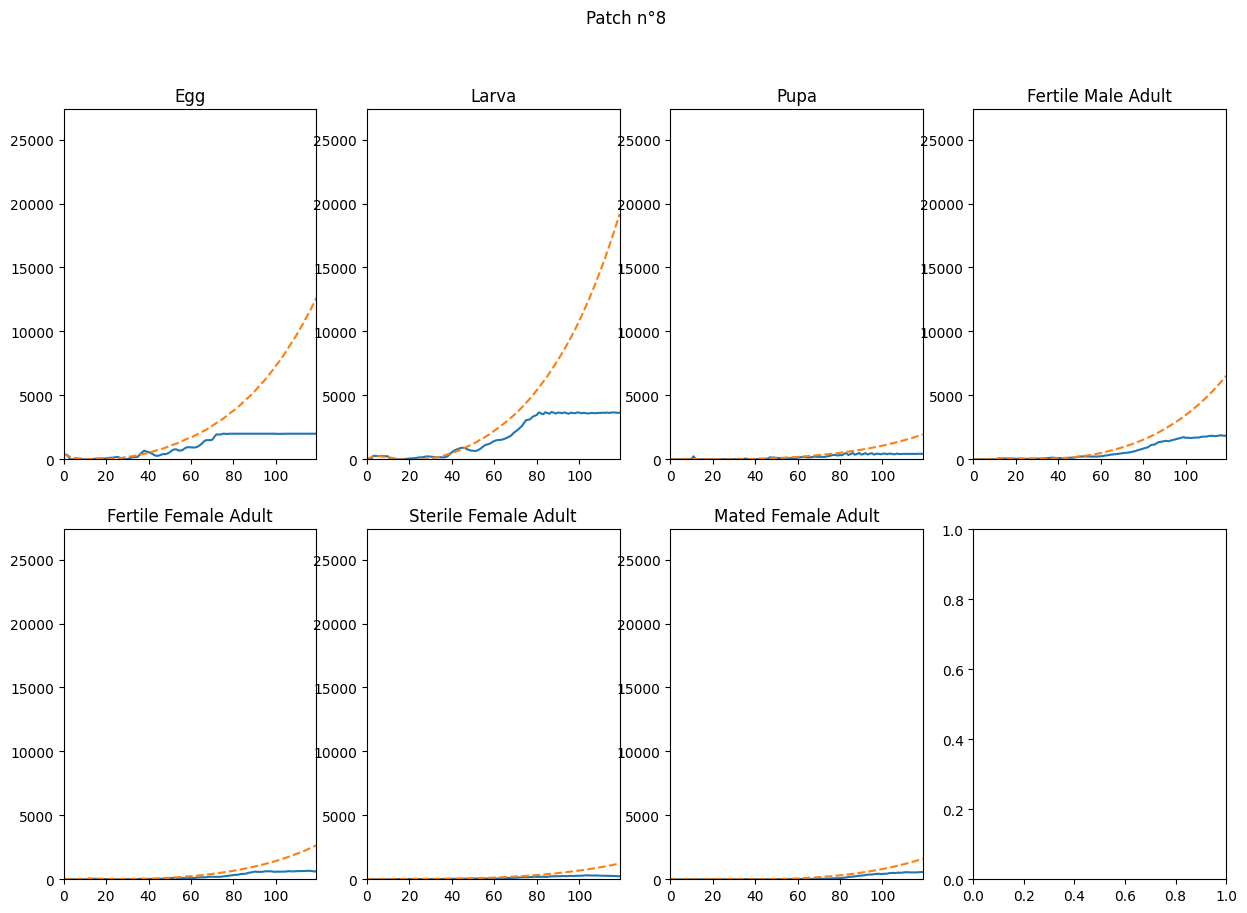

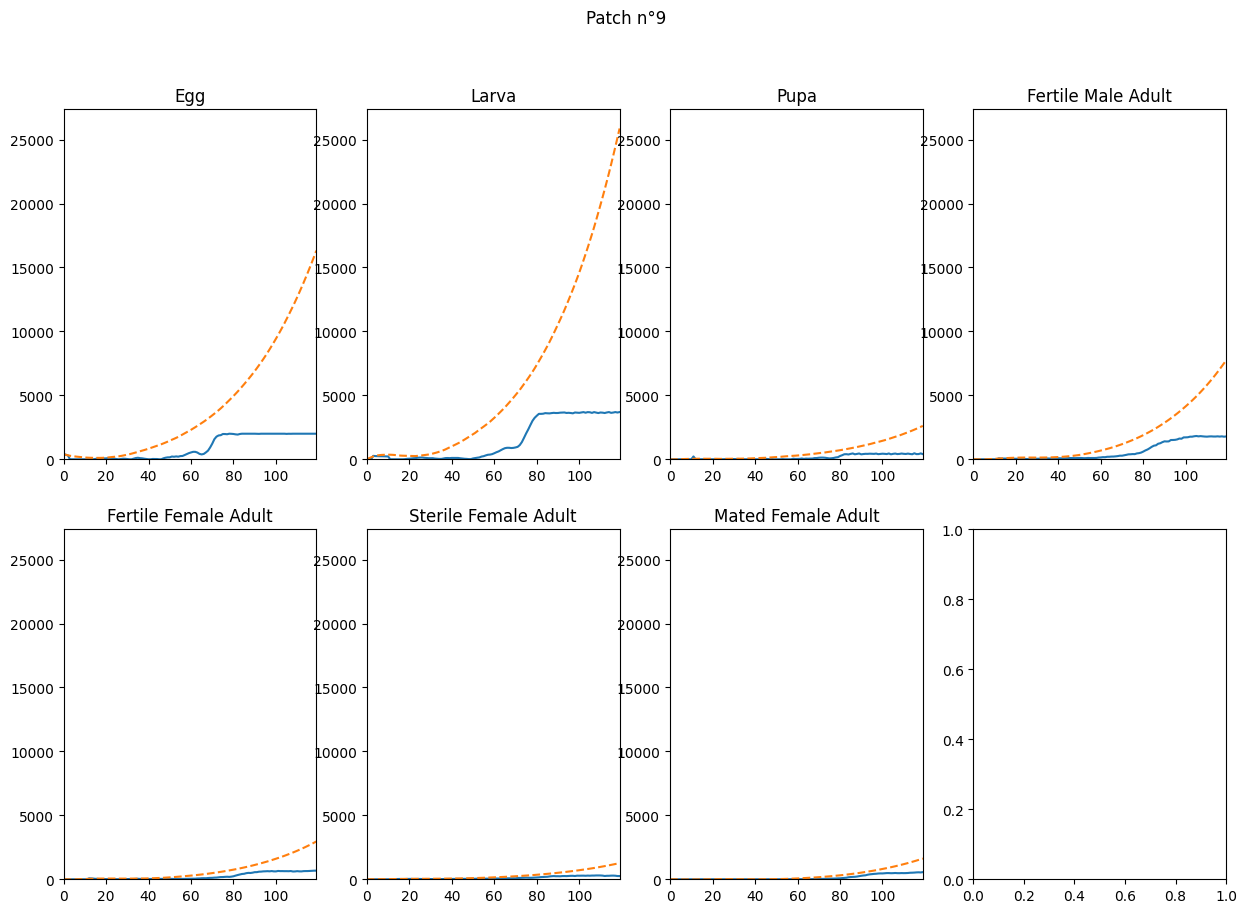

In [28]:
for i in range(10):
    draw_prediction(Y_test, Y_pred_move, i)


In [25]:
X_test.shape

(120, 80)